# Comics Rx
## [A comic book recommendation system](https://github.com/MangrobanGit/comics_rx)
<img src="https://images.unsplash.com/photo-1514329926535-7f6dbfbfb114?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=2850&q=80" width="400" align='left'>

---

# 6 - ALS Model - Reduced Data: Grid Search + Cross-Validation

This time, as explored in the EDA NB, let's consider removing customers who we feel have too few or too many purchases to influence the model in the intended way.

Examples:
- Too few - Customers who have only bought 1 comic (series).
- Too many - Customers with > 1000 series (for example, think all eBay customers are rolled into one account number).

# Libraries

In [1]:
%matplotlib inline
%load_ext autoreload
# %autoreload 1 #would be where you need to specify the files
# %aimport comic_recs

import pandas as pd # dataframes
import os
import pickle

# Data storage
from sqlalchemy import create_engine # SQL helper
#import psycopg2 as psql #PostgreSQL DBs

# import necessary libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
# from pyspark.sql.types import (StructType, StructField, IntegerType
#                                ,FloatType, LongType, StringType)
from pyspark.sql.types import *

import pyspark.sql.functions as F
from pyspark.sql.functions import col, explode, lit, isnan, when, count
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import DataFrame

# Custom
import lib.data_fcns as dfc
import lib.keys  # Custom keys lib
import lib.comic_recs as cr

import time
import itertools
from functools import reduce
import numpy as np

In [2]:
# instantiate SparkSession object
spark = pyspark.sql.SparkSession.builder.master("local[*]").getOrCreate()
# spark = SparkSession.builder.master("local").getOrCreate()

In [8]:
# spark config
spark = SparkSession \
    .builder \
    .appName("movie recommendation") \
    .config("spark.driver.maxResultSize", "1g") \
    .config("spark.driver.memory", "1g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.master", "local[*]") \
    .getOrCreate()

## Import Data

We've previously set aside the dataset into a `json` file.

In [9]:
# We have previously created a version of the transactions table and filtered it down.
sold = spark.read.json('raw_data/als_input_filtered.json')

In [10]:
# Persist the data
sold.persist()

DataFrame[account_id: bigint, bought: bigint, comic_id: bigint]

### ALS Model

Let's start with  train/test split.

In [11]:
# Split data into training and test set
(train, test) = sold.randomSplit([.8, .2], seed=41916)

Make sure shapes make sense.

In [12]:
print(train.count(), len(train.columns))

49402 3


In [13]:
print(test.count(), len(test.columns))

12469 3


In [14]:
# Evaluate the model by computing the RMSE on the test data
eval_reg = RegressionEvaluator(metricName="rmse"
                               , labelCol="bought"
                               , predictionCol="prediction")

### Grid Search

In [21]:
# hyper-param config
num_iterations = [10, 20]
ranks = [5, 10, 15, 20]
reg_params = [0.01, 0.1, 0.5]
alphas = [1, 50, 500, 1000, 5000]

Let's further subset into test and validation sets.

In [16]:
# Split data into training and validation sets
(gs_train, gs_val) = train.randomSplit([.8, .2], seed=41916)

In [17]:
print(gs_train.count(), len(gs_train.columns))

39457 3


In [18]:
print(gs_val.count(), len(gs_val.columns))

9945 3


In [22]:
# grid search and select best model
start_time = time.time()
#final_model, param_errors = tr_ALS(train, test, eval_reg, num_iterations, reg_params, ranks, alphas)
final_model, params_errs = cr.train_ALS(gs_train, gs_val, eval_reg, num_iterations, reg_params, ranks, alphas)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

10 iterations, 5 latent factors, regularization=0.01, and alpha @ 1 : validation error is 0.8618
10 iterations, 5 latent factors, regularization=0.01, and alpha @ 50 : validation error is 0.4835
10 iterations, 5 latent factors, regularization=0.01, and alpha @ 500 : validation error is 0.3411
10 iterations, 5 latent factors, regularization=0.01, and alpha @ 1000 : validation error is 0.3285
10 iterations, 5 latent factors, regularization=0.01, and alpha @ 5000 : validation error is 0.3250
10 iterations, 10 latent factors, regularization=0.01, and alpha @ 1 : validation error is 0.8451
10 iterations, 10 latent factors, regularization=0.01, and alpha @ 50 : validation error is 0.4952
10 iterations, 10 latent factors, regularization=0.01, and alpha @ 500 : validation error is 0.4145
10 iterations, 10 latent factors, regularization=0.01, and alpha @ 1000 : validation error is 0.4219
10 iterations, 10 latent factors, regularization=0.01, and alpha @ 5000 : validation error is 0.4680
10 iter

20 iterations, 5 latent factors, regularization=0.1, and alpha @ 1000 : validation error is 0.3143
20 iterations, 5 latent factors, regularization=0.1, and alpha @ 5000 : validation error is 0.3239
20 iterations, 10 latent factors, regularization=0.1, and alpha @ 1 : validation error is 0.8494
20 iterations, 10 latent factors, regularization=0.1, and alpha @ 50 : validation error is 0.4890
20 iterations, 10 latent factors, regularization=0.1, and alpha @ 500 : validation error is 0.3956
20 iterations, 10 latent factors, regularization=0.1, and alpha @ 1000 : validation error is 0.3965
20 iterations, 10 latent factors, regularization=0.1, and alpha @ 5000 : validation error is 0.4443
20 iterations, 15 latent factors, regularization=0.1, and alpha @ 1 : validation error is 0.8409
20 iterations, 15 latent factors, regularization=0.1, and alpha @ 50 : validation error is 0.5112
20 iterations, 15 latent factors, regularization=0.1, and alpha @ 500 : validation error is 0.4558
20 iterations,

Save the descriptive results

In [23]:
param_errs_rd_1 = params_errs

In [24]:
with open('support_data/params_errs_rd1.pkl', 'wb') as f:
    pickle.dump(param_errs_rd_1, f)
    
# Example - load pickle
# pickle_in = open("support_data/params_errs_rd1.pkl","rb")
# pe1 = pickle.load(pickle_in)

Hmmm. Let's put `params_errs` into a dataframe and find the model with the lowest error!

In [25]:
gs_cols = ['max_iters', 'reg', 'rank', 'alpha', 'rmse']

In [26]:
gs_df = pd.DataFrame(params_errs, columns=gs_cols)

In [27]:
gs_df.head()

,max_iters,reg,rank,alpha,rmse
0,10,0.01,5,1,0.861754
1,10,0.01,5,50,0.483533
2,10,0.01,5,500,0.341092
3,10,0.01,5,1000,0.328459
4,10,0.01,5,5000,0.324995


In [28]:
min_err = gs_df.rmse.min()

In [49]:
min_df = gs_df.loc[gs_df['rmse']==min_err]

In [65]:
best_max_iter = min_df['max_iters'].iloc[0]
best_reg = min_df['reg'].iloc[0]
best_rank = min_df['rank'].iloc[0]
best_alpha = min_df['alpha'].iloc[0]

Let's do some visual comparisons.

In [67]:
gs_rank_match = (gs_df['rank']==best_rank)
gs_reg_match = (gs_df['reg']==best_reg)
gs_iter_match = (gs_df['max_iters']==best_max_iter)
gs_alpha_match = (gs_df['alpha']==best_alpha)

In [69]:
gs_vary_rank = gs_df.loc[(gs_reg_match & gs_iter_match & gs_alpha_match),:]

In [70]:
gs_vary_rank

,max_iters,reg,rank,alpha,rmse
103,20,0.5,5,1000,0.311754
108,20,0.5,10,1000,0.388065
113,20,0.5,15,1000,0.452006
118,20,0.5,20,1000,0.512826


In [71]:
gs_vary_alpha = gs_df.loc[(gs_reg_match & gs_iter_match & gs_rank_match),:]

In [73]:
gs_vary_alpha

,max_iters,reg,rank,alpha,rmse
100,20,0.5,5,1,0.913288
101,20,0.5,5,50,0.482446
102,20,0.5,5,500,0.322004
103,20,0.5,5,1000,0.311754
104,20,0.5,5,5000,0.320347


In [74]:
gs_vary_reg = gs_df.loc[(gs_alpha_match & gs_iter_match & gs_rank_match),:]

In [75]:
gs_vary_reg

,max_iters,reg,rank,alpha,rmse
63,20,0.01,5,1000,0.314909
83,20,0.10,5,1000,0.314317
103,20,0.50,5,1000,0.311754


In [78]:
gs_vary_iter = gs_df.loc[(gs_alpha_match & gs_reg_match & gs_rank_match),:]

In [79]:
gs_vary_iter

,max_iters,reg,rank,alpha,rmse
43,10,0.5,5,1000,0.325782
103,20,0.5,5,1000,0.311754


So quick inspection on these, lets:
- keep `rank` = 5
- When compared to all the other combos, the differences in `alpha`s seem to not really move the needle > 500. so let's just call it `1000`
- Keep `maxIter` at `20`; experience to date with my assets seems to show 20 is max capability before technical difficulties arise.
- Similar with `alpha`, the marginal change in error due to changing `reg` is really small. So let's just assume the default `.01`.

So, that means we are done selecting! We may really be pushing overfitting.

One last thing, let chart change in RMSE over change in alpha.

In [87]:
alpha_graph_df = gs_vary_alpha.copy()

In [162]:
alpha_graph_df['params_desc'] = (
                                '\u03B1=' + alpha_graph_df['alpha'].map(str) 
                                )
                                 

In [163]:
alpha_graph_df

,max_iters,reg,rank,alpha,rmse,params_desc
100,20,0.5,5,1,0.913288,α=1
101,20,0.5,5,50,0.482446,α=50
102,20,0.5,5,500,0.322004,α=500
103,20,0.5,5,1000,0.311754,α=1000
104,20,0.5,5,5000,0.320347,α=5000


In [164]:
import seaborn as sns
import matplotlib.pyplot as plt

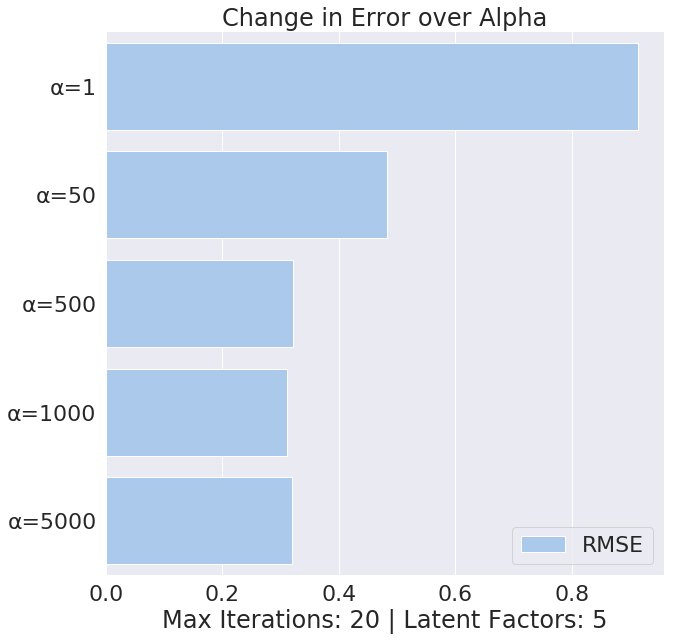

In [198]:
sns.set(style="whitegrid")
sns.set(font_scale=2)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot RMSE
sns.set_color_codes("pastel")
s = sns.barplot(x="rmse", y="params_desc", data=alpha_graph_df,
            label="RMSE", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="",
       xlabel="Max Iterations: 20 | Latent Factors: 5")
ax.set_title("Change in Error over Alpha")
sns.despine(left=True, bottom=True)

fig = s.get_figure()
fig.savefig('support_data/alphas.png') 

**OK**. Let's call it good. 

## Results 
Looks like the best parameters we could find are:
- `maxIter` = 20
- `rank` = 5
- `regParam` = 0.1 (default)
- `alpha` = 1000

Let's cross-validate this candidate model.

## Cross Validation

Let's cross-validate because we didn't actually do it in the grid search. We want to make sure that the selected model is not overfitting.

The built-in cross validator in `Spark` keeps breaking when I try to use it, so let's build our own function.

In [166]:
k = 5
random_seed = 41916

In [172]:
folds = cr.get_spark_k_folds(train, k=5, random_seed=random_seed)

In [173]:
# Create ALS instance for cv with our chosen parametrs
als_cv = ALS(maxIter=best_max_iter,
          rank=best_rank,
          userCol='account_id',
          itemCol='comic_id',
          ratingCol='bought',
          implicitPrefs=True,
          regParam=best_reg,
          alpha=best_alpha,
          coldStartStrategy='drop', # we want to drop so can get through CV
          seed=41916)

In [174]:
errors = cr.get_cv_errors(folds, als_cv, eval_reg)

In [175]:
# Make sure that # of errors = k
k == len(errors)

True

In [180]:
print("Accuracy: %0.3f (+/- %0.3f)" % (np.mean(errors), np.std(errors) * 2))

Accuracy: 0.310 (+/- 0.017)


Looks stable. Let's go with it.

## Test the Candidate Model

Test vs our holdout set.

In [193]:
# Create ALS instance and fit model
als = ALS(maxIter=best_max_iter,
          rank=best_rank,
          userCol='account_id',
          itemCol='comic_id',
          ratingCol='bought',
          implicitPrefs=True,
          regParam=best_reg,
          alpha=1000,
          coldStartStrategy='drop', # To get our eval
          seed=41916)
model_use = als.fit(train)

In [194]:
# get predictions on test
test_preds = model_use.transform(test)

# Evaluate test
test_rmse = eval_reg.evaluate(test_preds)
test_rmse

0.2658167707438543

### Get Top N recommendations for Single User

Let's make a reference list of `account_id`'s, for testing purposes.

In [11]:
n_to_test = 2

users = (sold.select(als.getUserCol())
                          .sample(False
                                  ,n_to_test/sold.count()
                                  )
        )
users.persist()
users.show(2)

+----------+
|account_id|
+----------+
|       192|
|       569|
+----------+



We developed and wrote the functionality out to a function in `comic_recs.py`

###  Testing function!

- Pass the function to a pandas dataframe. 
- Function will ask for an account_id.
- Will return top n, n defined in parameters.

In [10]:
top_n_df = cr.get_top_n_new_recs(spark=spark, model=model_use, topn=5)
top_n_df

192
Total Runtime: 28.51 seconds


,comic_title
1,Brightest Day (DC)
2,New Mutants (Marvel)
3,Fear Itself (Marvel)
4,Batman Incorporated (DC)
5,Birds of Prey (DC)


In [11]:
top_n_df = cr.get_top_n_new_recs(spark=spark, model=model_use, topn=5)
top_n_df

569
Total Runtime: 29.68 seconds


,comic_title
1,Thor (Marvel)
2,Superior Spider-Man (Marvel)
3,Invincible (Image)
4,Image Firsts Saga Curr Ptg (Image)
5,Superior Iron Man (Marvel)


In [12]:
top_n_df = cr.get_top_n_new_recs(spark=spark, model=model_use, topn=10)
top_n_df

161
Total Runtime: 21.43 seconds


,comic_title
1,Aliens Dead Orbit (Dark Horse)
2,Beef (Image)
3,Vinegar Teeth (Dark Horse)
4,Leviathan (Image)
5,Shaolin Cowboy Wholl Stop th (Dark Horse)
6,Head Lopper (Image)
7,Crossed Badlands (Avatar)
8,Punisher (Marvel)
9,Godzilla Oblivion (IDW)
10,Nova (Marvel)


## Conclusions
- Seems realistic? Only three tests, but the results seem 'individualized' in the sense that there is no overlap between the sets (albeit small samples).

## Save the Model!

In [13]:
model_use.save('als_use')

## Retrieving Saved Model

In [14]:
comic_rec_model = ALSModel.load('als_use')

In [15]:
top_n_df = cr.get_top_n_new_recs(spark=spark, model=comic_rec_model, topn=10)
top_n_df

161
Total Runtime: 5.66 seconds


,comic_title
1,Aliens Dead Orbit (Dark Horse)
2,Beef (Image)
3,Vinegar Teeth (Dark Horse)
4,Leviathan (Image)
5,Shaolin Cowboy Wholl Stop th (Dark Horse)
6,Head Lopper (Image)
7,Crossed Badlands (Avatar)
8,Punisher (Marvel)
9,Godzilla Oblivion (IDW)
10,Nova (Marvel)
